# Horizon holes filling

**Author: M. Ravasi, KAUST**

Welcome to the **Matrix-free inverse problems with PyLops** tutorial!

The aim of this tutorial is to fill holes in seismic horizons (also known in the computer vision community as **inpainting**). 


This notebook uses an horizon from Matt's paper [M. Hall (2007). Smooth operator: Smoothing seismic interpretations and attributes. The Leading Edge 26, p16–20](https://library.seg.org/doi/10.1190/1.2431821) and it is heavily inspired by [S. Fomel DWT jupyter notebook](https://github.com/sfomel/ipython/blob/master/DWT.ipynb) As a by-product you will learn to:

- Familiarize with the `pylops.signalprocessing` submodule, and more specifically with the 2D-FFT (``FFT2D``) and Wavelet transform (``DWT``);
- Learn how to use sparse solvers within the `pylops.optimization.sparsity` submodule, and more specifically the FISTA solver.

From a mathematical point of view we write the impainting problem as follows:

$$
J = arg min_{\mathbf{p}} ||\mathbf{d} - \mathbf{M} \mathbf{P} \mathbf{p}||_2 + \epsilon ||\mathbf{p}||_1
$$

where $\mathbf{M}$ is a masking operator, $\mathbf{P}$ is a sparsyfing transform, $\mathbf{d}$ is the horizon with holes, and $\mathbf{m}=\mathbf{P}\mathbf{p}$ is the filled horizon we wish to obtain.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops scooby

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scooby

from pylops.basicoperators import *
from pylops.optimization.sparsity import *
from pylops.signalprocessing import FFT2D, DWT, DWT2D
from pylops.utils.tapers import taper2d

## Data loading

Let's start by loading a seismic horizon

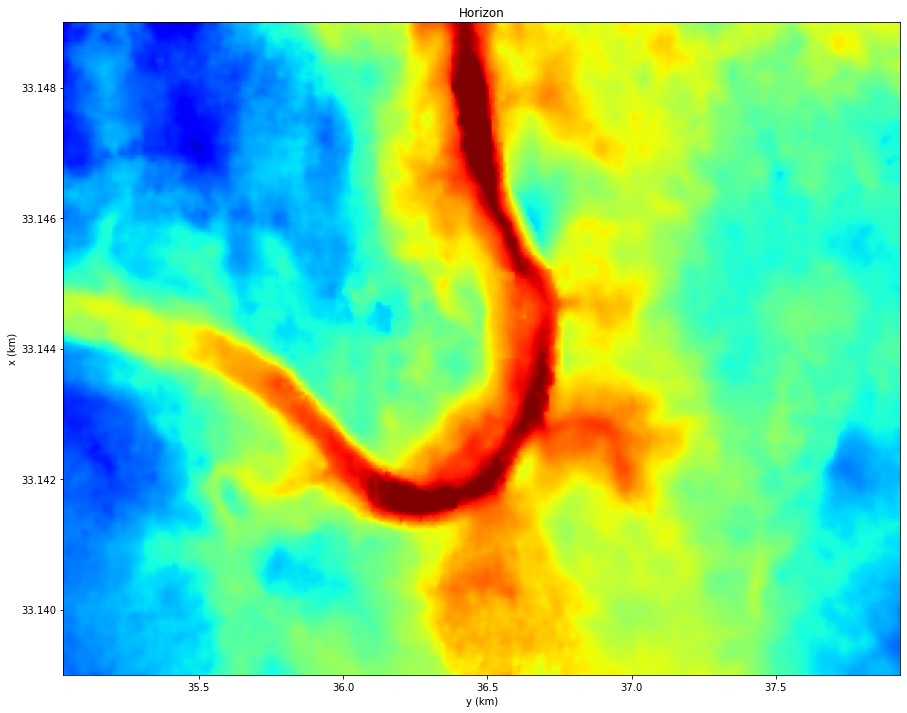

In [3]:
# You can download this horizon using Madagascar's command: Fetch('horizon.asc','hall')
# And it is now also provided in our data folder.
f = np.loadtxt('data/horizon.asc')
ig = f[:, -1]-65
ig = ig.reshape(291, 196).T
nyorig, nxorig = ig.shape
y = 33.139 + np.arange(nyorig) * 0.01
x = 35.031 + np.arange(nxorig) * 0.01

# We apply some tapering on the edges
#tap = taper2d(nxorig, nyorig, (25, 25))
#ig = ig * tap

# Pad to closest multiple of 2 (for DWT)
ig = np.pad(ig, ((0, 256-nyorig), (0, 512-nxorig)))
ny, nx = ig.shape

plt.figure(figsize=(15, 12))
plt.imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
           extent=(x[0], x[-1], y[0], y[1]), origin='lower')
plt.xlabel('y (km)')
plt.ylabel('x (km)')
plt.title('Horizon')
plt.axis('tight');

Let's now create some holes in the horizon

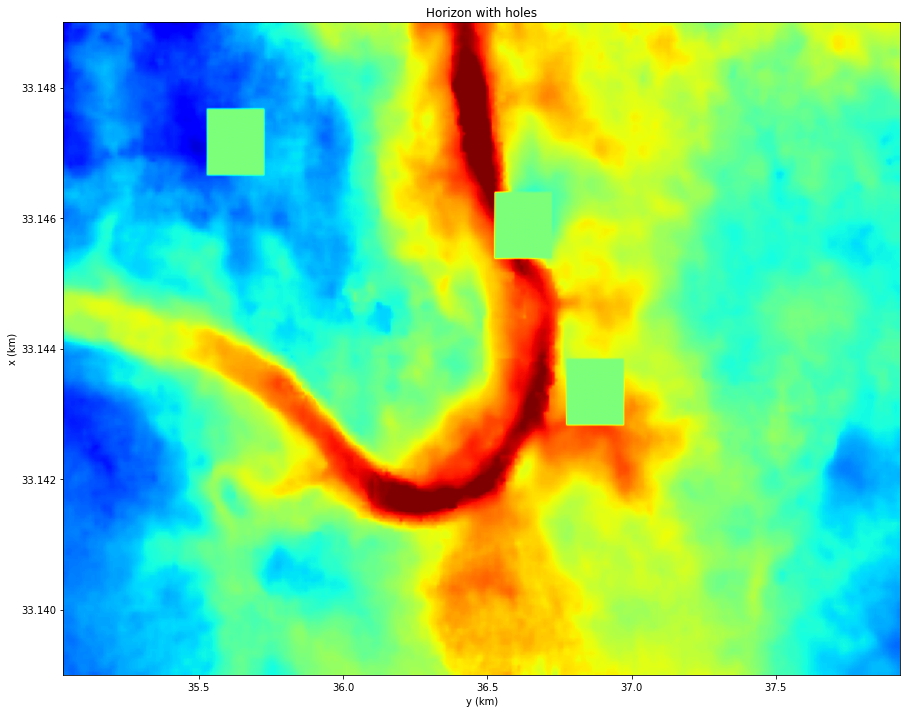

In [4]:
mask = np.ones_like(ig)
mask[125:145, 150:170] = 0
mask[150:170, 50:70] = 0
mask[75:95, 175:195] = 0
igholes = ig * mask

plt.figure(figsize=(15, 12))
plt.imshow(igholes[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
           extent=(x[0], x[-1], y[0], y[1]), origin='lower')
plt.xlabel('y (km)')
plt.ylabel('x (km)')
plt.title('Horizon with holes')
plt.axis('tight');

## Reconstruction with DWT

First of all we need to create the sparsyfing operator

/Users/ravasim/opt/anaconda3/envs/pylops/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


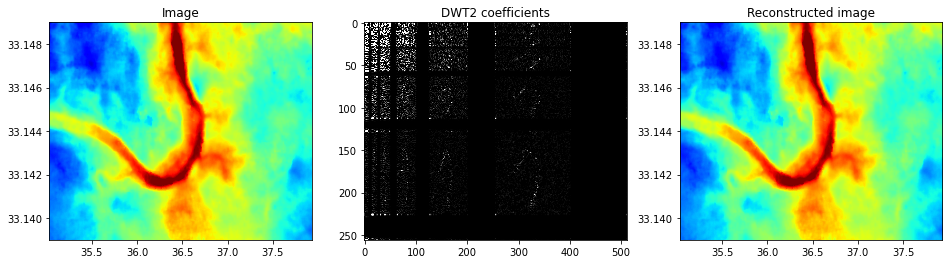

In [5]:
wavkind = 'sym9'

# Cascaded DWT
Wopy, Wopx = DWT((ny,nx), 1, wavelet=wavkind, level=5), DWT((ny,nx), 0, wavelet=wavkind, level=5)
Wop = Wopy*Wopx
dimswav = Wopy.dimsd

# DWT2D
#Wop = DWT2D((ny, nx), wavelet=wavkind, level=5)
#dimswav = Wop.dimsd

ig_wav = Wop * ig.ravel()
iginv = Wop.H * ig_wav
iginv = iginv.reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(ig_wav.reshape(dimswav), cmap='gray', vmin=0, vmax=5e-1)
axs[1].set_title('DWT2 coefficients')
axs[1].axis('tight')
axs[2].imshow(iginv[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Reconstructed image')
axs[2].axis('tight');

Let's now solve the inverse problem

FISTA optimization (soft-percentile thresholding)
-----------------------------------------------------------
The Operator Op has 131072 rows and 131072 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	perc = 10.0
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -2.13550e+02   3.678e+02   2.794e+03   1.180e+03
     2  -2.13552e+02   3.622e+02   2.783e+03   3.994e+00
     3  -2.13554e+02   3.575e+02   2.773e+03   4.574e+00
     4  -2.13555e+02   3.551e+02   2.763e+03   5.078e+00
     5  -2.13556e+02   3.527e+02   2.753e+03   5.554e+00
     6  -2.13556e+02   3.509e+02   2.743e+03   5.982e+00
     7  -2.13557e+02   3.492e+02   2.733e+03   6.428e+00
     8  -2.13558e+02   3.468e+02   2.723e+03   6.798e+00
     9  -2.13559e+02   3.443e+02   2.713e+03   7.095e+00
    10  -2.13560e+02   3.417e+02   2.703e+03   7.279e+00
    11  -2.13560e+02   3.400e+02   2.695e+03   7.347e+00
    21  -2.1356

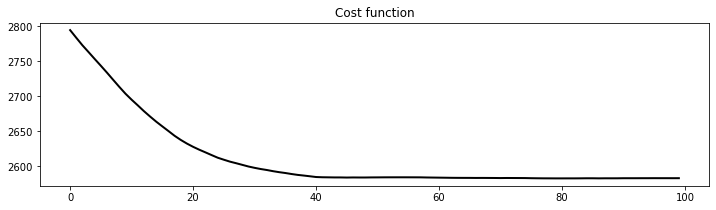

In [6]:
Op = Diagonal(mask.ravel())

igdata = Op * ig.ravel()
igfilled_wav, niter, cost = FISTA(Op * Wop.H, igdata, niter=100, 
                                  #threshkind='soft', eps=1e1, 
                                  threshkind='soft-percentile', perc=10, 
                                  returninfo=True, show=True)
igfilled = np.real((Wop.H * igfilled_wav).reshape(ny, nx))

plt.figure(figsize=(12, 3))
plt.plot(cost, 'k', lw=2)
plt.title('Cost function');

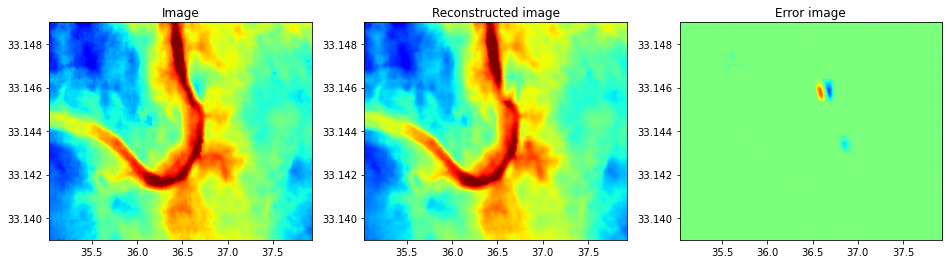

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[1].set_title('Reconstructed image')
axs[1].axis('tight');
axs[2].imshow(ig[:nyorig, :nxorig]-igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Error image')
axs[2].axis('tight');

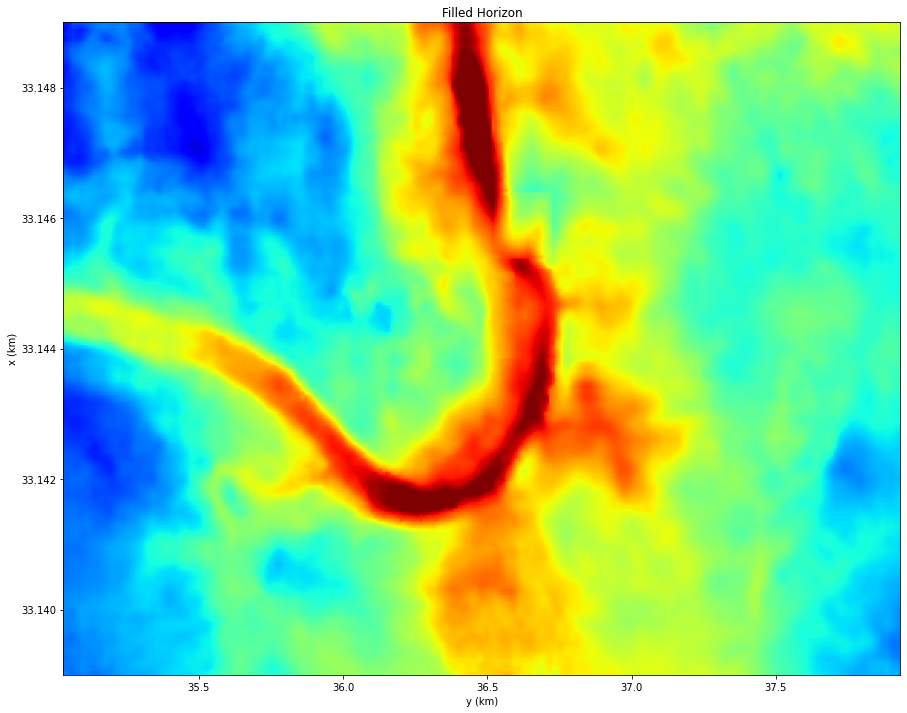

In [8]:
plt.figure(figsize=(15, 12))
plt.imshow(igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
           extent=(x[0], x[-1], y[0], y[1]), origin='lower')
plt.xlabel('y (km)')
plt.ylabel('x (km)')
plt.title('Filled Horizon')
plt.axis('tight');

At this point you may wonder if the DWT is the best sparsifying transform for this data. 

I encourage you to experiment with more transforms, for example:

- ``FFT2D`` (as shown below);
- ``Curvelet`` transform (see [curvelops](https://github.com/PyLops/curvelops) for a PyLops wrapper);
- Other transforms such as the Shearlet transform (you try to wrap [pyshearlab](http://na.math.uni-goettingen.de/pyshearlab/) into PyLops).

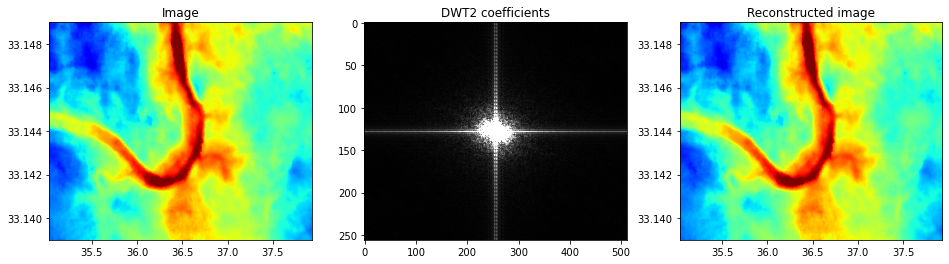

In [9]:
Wop = FFT2D((ny, nx))
ig_wav = Wop * ig.ravel()
igholes_wav = Wop * igholes.ravel()
iginv = Wop.H * ig_wav
iginv = np.real(iginv).reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(np.abs(np.reshape(ig_wav, (ny,nx)))), 
              cmap='gray', vmin=0, vmax=5)
axs[1].set_title('DWT2 coefficients')
axs[1].axis('tight')
axs[2].imshow(iginv[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Reconstructed image')
axs[2].axis('tight');

FISTA optimization (soft-percentile thresholding)
-----------------------------------------------------------
The Operator Op has 131072 rows and 131072 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	perc = 10.0
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   9.37598e+00   3.312e+03   6.465e+03   1.165e+03
     2   9.72815e+00   2.777e+03   5.926e+03   2.491e+01
     3   1.00406e+01   2.461e+03   5.607e+03   2.177e+01
     4   1.03056e+01   2.307e+03   5.442e+03   1.914e+01
     5   1.05361e+01   2.224e+03   5.346e+03   1.724e+01
     6   1.07374e+01   2.179e+03   5.289e+03   1.577e+01
     7   1.09111e+01   2.161e+03   5.259e+03   1.457e+01


/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/optimization/sparsity.py:1099: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = '%6g  %12.5e  %10.3e   %9.3e  %10.3e' % \


     8   1.10651e+01   2.148e+03   5.235e+03   1.364e+01
     9   1.12026e+01   2.132e+03   5.213e+03   1.286e+01
    10   1.13216e+01   2.129e+03   5.202e+03   1.217e+01
    11   1.14275e+01   2.124e+03   5.192e+03   1.159e+01
    21   1.21523e+01   2.117e+03   5.165e+03   4.671e+00
    31   1.25355e+01   2.119e+03   5.166e+03   1.236e+00
    41   1.23711e+01   2.120e+03   5.166e+03   1.134e+00
    51   1.21924e+01   2.119e+03   5.166e+03   5.629e-01
    61   1.22937e+01   2.118e+03   5.165e+03   3.963e-01
    71   1.23834e+01   2.118e+03   5.165e+03   2.951e-01
    81   1.23040e+01   2.119e+03   5.166e+03   1.610e-01
    91   1.22670e+01   2.119e+03   5.165e+03   1.657e-01
    92   1.22706e+01   2.119e+03   5.165e+03   1.698e-01
    93   1.22752e+01   2.119e+03   5.165e+03   1.698e-01
    94   1.22807e+01   2.119e+03   5.165e+03   1.660e-01
    95   1.22868e+01   2.119e+03   5.165e+03   1.585e-01
    96   1.22933e+01   2.118e+03   5.165e+03   1.479e-01
    97   1.23000e+01   2.118e+0

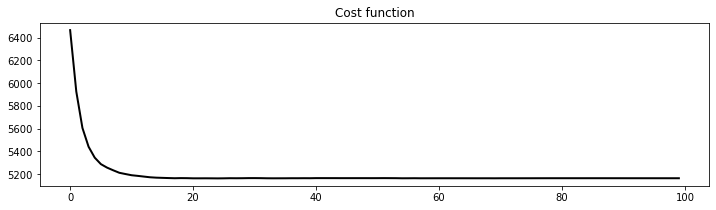

In [10]:
Op = Diagonal(mask.ravel())

igdata = Op * ig.ravel()
igfilled_wav, niter, cost = FISTA(Op * Wop.H, igdata.astype(np.complex), niter=100, 
                                  #threshkind='soft', eps=1e1, 
                                  threshkind='soft-percentile', perc=10, 
                                  returninfo=True, show=True)
igfilled = np.real((Wop.H * igfilled_wav).reshape(ny, nx))

plt.figure(figsize=(12, 3))
plt.plot(cost, 'k', lw=2)
plt.title('Cost function');

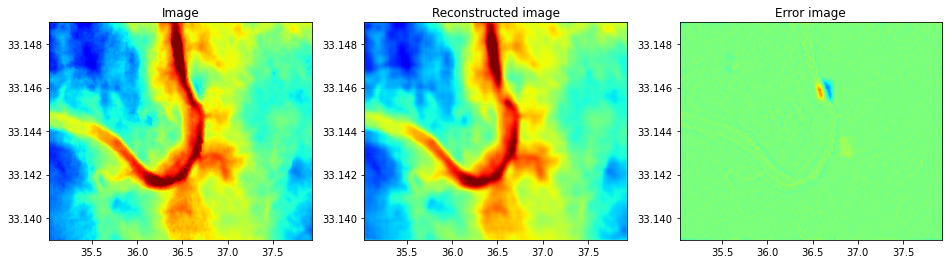

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[1].set_title('Reconstructed image')
axs[1].axis('tight');
axs[2].imshow(ig[:nyorig, :nxorig]-igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Error image')
axs[2].axis('tight');

In [12]:
scooby.Report(core='pylops')

--------------------------------------------------------------------------------
  Date: Mon Apr 19 16:39:57 2021 +03

                OS : Darwin
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.5 (default, Sep  4 2020, 02:22:02)  [Clang 10.0.0 ]

            pylops : 1.12.1.dev37+g28a66cc.d20210326
             numpy : 1.19.2
             scipy : 1.5.2
           IPython : 7.19.0
        matplotlib : 3.3.2
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------